## Analysing performance of Rocket based classifier 

In [114]:
import sys

sys.path.insert(0, "..")

from joblib import Parallel, delayed

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt

from HAR.transformers import CSIMinMaxScaler, Rocket
from HAR.classifiers import RidgeVotingClassifier
from HAR.io import load_dataset


class RidgeVotingClassifierExt(RidgeVotingClassifier):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def predict(self, X):
        n_samples, n_sc, *_ = X.shape
        final_predictions = np.zeros((n_samples,))
        disagree_sc = []
        for isample in range(n_samples):
            predictions = Parallel(n_jobs=1, backend="threading")(
                delayed(self._score)(
                    self._models[m_], np.expand_dims(X[isample, m_, :], axis=0)
                )
                for m_ in range(n_sc)
            )

            predictions = np.array(predictions).squeeze()
            unique, counts = np.unique(predictions, return_counts=True)
            best = unique[np.argmax(counts)]
            final_predictions[isample] = best

            # print(predictions.shape)
            disagree_sc.extend(list(np.where(predictions != best)))

        return final_predictions, disagree_sc


pipe = Pipeline(
    [
        ("scaler", CSIMinMaxScaler()),
        (
            "rocket",
            Rocket(n_kernels=500),
        ),
        (
            "classifier",
            RidgeVotingClassifierExt(n_classes=3),
        ),
    ]
)

In [115]:
X, y, nsamples, classnames, dim = load_dataset("../dataset/rCSI-d1d2")
X = X.reshape(X.shape[0], *dim)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

pipe.fit_transform(X_train, y_train)
pipe["rocket"].save("../artifacts/nbs-v1/kernels.pkl")
pipe["classifier"].save("../artifacts/nbs-v1/models.pkl")

# pipe["rocket"].load("../artifacts/nbs-v1/kernels.pkl")
# pipe["classifier"].load("../artifacts/nbs-v1/models.pkl")

Kernel Transform


100%|██████████| 54/54 [00:18<00:00,  3.00it/s]


In [116]:
y_pred, disagree_sc1 = pipe.predict(X_test)

print(f"\n> Test Accuracy: {accuracy_score(y_test, y_pred)*100:.4f}%")
print("\n> Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\n> Classification Report :")
print(classification_report(y_test, y_pred, target_names=classnames))

Kernel Transform


100%|██████████| 254/254 [00:08<00:00, 29.12it/s]



> Test Accuracy: 96.6667%

> Confusion Matrix: 
[[100   0   0]
 [  0  97   3]
 [  2   5  93]]

> Classification Report :
              precision    recall  f1-score   support

        Idle       0.98      1.00      0.99       100
        Walk       0.95      0.97      0.96       100
        Jump       0.97      0.93      0.95       100

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



In [117]:
import warnings

warnings.filterwarnings("ignore")

X, y, nsamples, classnames, dim = load_dataset("../dataset/rCSI-d3")
X = X.reshape(X.shape[0], *dim)

y_pred, disagree_sc2 = pipe.predict(X)

print(f"\n> Test Accuracy: {accuracy_score(y, y_pred)*100:.4f}%")
print("\n> Confusion Matrix: ")
print(confusion_matrix(y, y_pred))
print("\n> Classification Report :")
print(classification_report(y, y_pred, target_names=classnames))

Kernel Transform


100%|██████████| 431/431 [00:16<00:00, 26.07it/s]



> Test Accuracy: 96.2745%

> Confusion Matrix: 
[[170   0   0]
 [  0 162   8]
 [  5   6 159]]

> Classification Report :
              precision    recall  f1-score   support

        Idle       0.97      1.00      0.99       170
        Walk       0.96      0.95      0.96       170
        Jump       0.95      0.94      0.94       170

    accuracy                           0.96       510
   macro avg       0.96      0.96      0.96       510
weighted avg       0.96      0.96      0.96       510



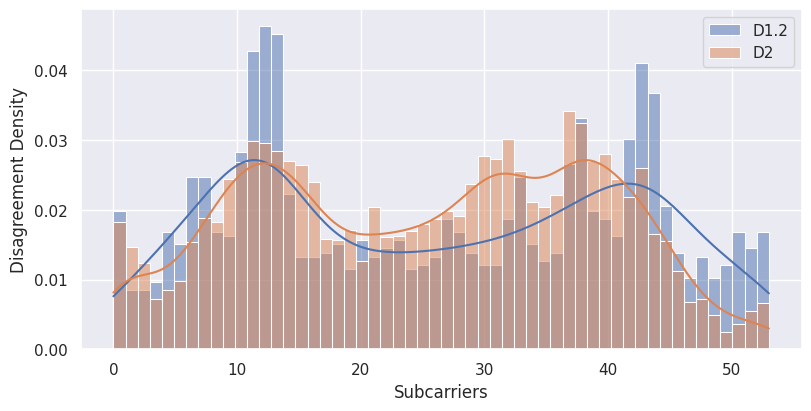

In [118]:
import seaborn as sns

sns.set_theme()

hist_kwargs = {"bins": 54, "kde": True, "stat": "density"}

plt.figure(figsize=(8, 4), constrained_layout=True)
sns.histplot(data=np.concatenate(disagree_sc1), **hist_kwargs, label="D1.2")
sns.histplot(data=np.concatenate(disagree_sc2), **hist_kwargs, label="D2")
plt.ylabel("Disagreement Density")
plt.xlabel("Subcarriers")
plt.legend()
plt.show()